In [65]:
# import packages 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, roc_curve, classification_report
from dmba import classificationSummary

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

plt.style.use('bmh')
%matplotlib inline

In [3]:
# import dataset 
df = pd.read_csv('final_0902_edited.csv',index_col = [0])
df.head()

,Control,State,Plan,2018 Fall Enrollment,Known_Cases_in_County_per_100k_Residents,lat,lng,institution,Address,Campus_Size,...,pct_change_2014_2015_gdp,pct_change_2015_2016_gdp,pct_change_2016_2017_gdp,pct_change_2017_2018_gdp,pct_change_gdp_avg,pct_change_2014_2015_income,pct_change_2015_2016_income,pct_change_2016_2017_income,pct_change_2017_2018_income,pct_change_income_avg
0,Public,MT,TBD,150.0,134,48.483856,-108.757664,Aaniiih Nakoda College,"269 Blackfeet Avenue Agency, Harlem, Montana 5...",Remote,...,-0.030642,-0.119080,-0.088707,0.195563,-0.010717,0.019461,-0.023339,0.012812,0.065942,0.018719
1,Private,TX,In-person,5204.0,790,32.469732,-99.708098,Abilene Christian University,", Abilene, Texas 79699",Midsize,...,-0.007143,-0.012588,0.020502,0.047747,0.012129,-0.032784,-0.015486,0.018699,0.057354,0.006946
2,Private,TX,TBD,2344.0,790,32.476850,-99.734056,Hardin-Simmons University,"2200 Hickory, Abilene, Texas 79698-0001",Midsize,...,-0.007143,-0.012588,0.020502,0.047747,0.012129,-0.032784,-0.015486,0.018699,0.057354,0.006946
3,Private,TX,Hybrid,1132.0,790,32.430380,-99.749702,McMurry University,"S 14th and Sayles Blvd, Abilene, Texas 79697",Midsize,...,-0.007143,-0.012588,0.020502,0.047747,0.012129,-0.032784,-0.015486,0.018699,0.057354,0.006946
4,Public,GA,Online,4291.0,3076,31.483076,-83.530194,Abraham Baldwin Agricultural College,"2802 Moore Hwy, Tifton, Georgia 31793-2601",Distant,...,0.104954,-0.089716,0.018626,0.030199,0.016016,0.088713,-0.034723,0.022256,0.045839,0.030521


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2433 entries, 0 to 2432
Data columns (total 68 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Control                                   2433 non-null   object 
 1   State                                     2433 non-null   object 
 2   Plan                                      2433 non-null   object 
 3   2018 Fall Enrollment                      2433 non-null   float64
 4   Known_Cases_in_County_per_100k_Residents  2433 non-null   int64  
 5   lat                                       2433 non-null   float64
 6   lng                                       2433 non-null   float64
 7   institution                               2433 non-null   object 
 8   Address                                   2433 non-null   object 
 9   Campus_Size                               2433 non-null   object 
 10  Housing                             

# Feature Engineer

## categorical Variable

In [17]:
cat_cols = df[[
    'Control', 'State', 'Plan', 'institution', 'Address', 'Campus_Size',
    'Housing', 'college_year', 'city', 'county', 'state', 'Campus_Location'
]]

cat_cols.head()

,Control,State,Plan,institution,Address,Campus_Size,Housing,college_year,city,county,state,Campus_Location
0,Public,MT,TBD,Aaniiih Nakoda College,"269 Blackfeet Avenue Agency, Harlem, Montana 5...",Remote,No,2,Harlem,Blaine,MT,Rural
1,Private,TX,In-person,Abilene Christian University,", Abilene, Texas 79699",Midsize,Yes,4,Abilene,Taylor,TX,City
2,Private,TX,TBD,Hardin-Simmons University,"2200 Hickory, Abilene, Texas 79698-0001",Midsize,Yes,4,Abilene,Taylor,TX,City
3,Private,TX,Hybrid,McMurry University,"S 14th and Sayles Blvd, Abilene, Texas 79697",Midsize,Yes,4,Abilene,Taylor,TX,City
4,Public,GA,Online,Abraham Baldwin Agricultural College,"2802 Moore Hwy, Tifton, Georgia 31793-2601",Distant,Yes,4,Tifton,Tift,GA,Town


In [22]:
# check any columns with only one values 
for column in cat_cols.columns:
  if len(cat_cols[column].value_counts())<= 1:
    print (column)
  else:print(column,'good to use!')

Control good to use!
State good to use!
Plan good to use!
institution good to use!
Address good to use!
Campus_Size good to use!
Housing good to use!
college_year good to use!
city good to use!
county good to use!
state good to use!
Campus_Location good to use!


In [33]:
test_col = [
    'Control', 'State','Campus_Size', 'Housing',
    'college_year', 'city','state','Campus_Location']

In [34]:
def chisquare_test(col):
  table=pd.crosstab(cat_cols['Plan'],cat_cols[col],margins=True)
  f_ob=np.array([table.iloc[0][0:len(table)].values,table.iloc[1][0:len(table)].values])
  result=chi2_contingency(f_ob)[0:3]
  if result[1]< 0.05: 
    print (col,'keep the variable',round(result[1],2))
  else : 
    print(col,'drop this variable',round(result[1],2))

In [35]:
for col in test_col:
  chisquare_test(col)

Control keep the variable 0.04
State keep the variable 0.0
Campus_Size keep the variable 0.01
Housing keep the variable 0.04
college_year drop this variable 0.76
city drop this variable 0.18
state keep the variable 0.0
Campus_Location keep the variable 0.01


## Number Col 

In [14]:
num_cols = [i for i in df.columns if i not in cat_cols]
num_data=df.loc[:,num_cols]
num_data.head()

,2018 Fall Enrollment,Known_Cases_in_County_per_100k_Residents,lat,lng,Total_All_Undergrad_Grant/Scholarship,AVG_All_Undergrad_Grant/Scholarship,Total_Federal_Student_Loans,AVG_Federal_Student_Loans_Amount,undergraduate_population,graduate_population,...,pct_change_2014_2015_gdp,pct_change_2015_2016_gdp,pct_change_2016_2017_gdp,pct_change_2017_2018_gdp,pct_change_gdp_avg,pct_change_2014_2015_income,pct_change_2015_2016_income,pct_change_2016_2017_income,pct_change_2017_2018_income,pct_change_income_avg
0,150.0,134,48.483856,-108.757664,819301.0,8716.0,0.0,0.0,131,0,...,-0.030642,-0.119080,-0.088707,0.195563,-0.010717,0.019461,-0.023339,0.012812,0.065942,0.018719
1,5204.0,790,32.469732,-99.708098,69502352.0,20187.0,19263408.0,10550.0,3525,1767,...,-0.007143,-0.012588,0.020502,0.047747,0.012129,-0.032784,-0.015486,0.018699,0.057354,0.006946
2,2344.0,790,32.476850,-99.734056,30714874.0,18110.0,6757086.0,6560.0,1742,582,...,-0.007143,-0.012588,0.020502,0.047747,0.012129,-0.032784,-0.015486,0.018699,0.057354,0.006946
3,1132.0,790,32.430380,-99.749702,15298291.0,15952.0,5748521.0,7408.0,1166,9,...,-0.007143,-0.012588,0.020502,0.047747,0.012129,-0.032784,-0.015486,0.018699,0.057354,0.006946
4,4291.0,3076,31.483076,-83.530194,16222202.0,4953.0,8519194.0,5679.0,3927,0,...,0.104954,-0.089716,0.018626,0.030199,0.016016,0.088713,-0.034723,0.022256,0.045839,0.030521


### PCA to reduce the dimension

**Method:** Dimension reduction because too many numeric variables. Avoid Dimension Curse

In [54]:
# transform data
ss = StandardScaler()
ss.fit(num_data)
transform_data = pd.DataFrame(data=ss.transform(num_data),
                              index=num_data.index,
                              columns=num_data.columns)
transform_data.head()

,2018 Fall Enrollment,Known_Cases_in_County_per_100k_Residents,lat,lng,Total_All_Undergrad_Grant/Scholarship,AVG_All_Undergrad_Grant/Scholarship,Total_Federal_Student_Loans,AVG_Federal_Student_Loans_Amount,undergraduate_population,graduate_population,...,pct_change_2014_2015_gdp,pct_change_2015_2016_gdp,pct_change_2016_2017_gdp,pct_change_2017_2018_gdp,pct_change_gdp_avg,pct_change_2014_2015_income,pct_change_2015_2016_income,pct_change_2016_2017_income,pct_change_2017_2018_income,pct_change_income_avg
0,-0.699733,-1.297786,2.074268,-1.160246,-0.648132,-0.220977,-0.599181,-2.546474,-0.714370,-0.387145,...,-1.269611,-2.406663,-3.373243,6.036066,-1.417694,-0.640025,-1.386496,-0.945961,1.276378,-1.178994
1,-0.153508,-0.573495,-1.175146,-0.579555,0.847437,1.018205,0.454963,2.089178,-0.258081,0.471480,...,-0.707771,-0.478947,0.077421,0.816262,-0.354724,-2.493156,-1.102681,-0.706859,0.655006,-2.073587
2,-0.462610,-0.573495,-1.173701,-0.581220,0.002842,0.793832,-0.229415,0.335979,-0.497787,-0.104338,...,-0.707771,-0.478947,0.077421,0.816262,-0.354724,-2.493156,-1.102681,-0.706859,0.655006,-2.073587
3,-0.593600,-0.573495,-1.183131,-0.582224,-0.332853,0.560709,-0.284607,0.708589,-0.575225,-0.382772,...,-0.707771,-0.478947,0.077421,0.816262,-0.354724,-2.493156,-1.102681,-0.706859,0.655006,-2.073587
4,-0.252183,1.950483,-1.375347,0.458547,-0.312735,-0.627484,-0.132988,-0.051131,-0.204036,-0.387145,...,1.972361,-1.875118,0.018152,0.196592,-0.173894,1.816324,-1.797908,-0.562416,-0.178183,-0.282150


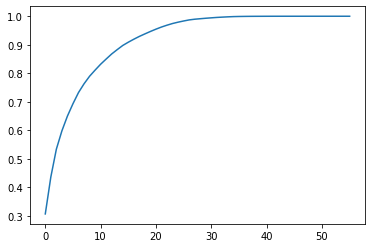

In [55]:
# fit PCA with the transform data 
pca=PCA()
pca.fit(transform_data)
ratio=pca.explained_variance_ratio_.cumsum()
plt.plot(ratio)

In [56]:
#pca summary
pcsSummary_df = pd.DataFrame({'Proportion of variance': pca.explained_variance_ratio_,
'Cumulative proportion': np.cumsum(pca.explained_variance_ratio_)}) 
pcsSummary_df

,Proportion of variance,Cumulative proportion
0,3.073074e-01,0.307307
1,1.293721e-01,0.436680
2,9.748627e-02,0.534166
3,6.410731e-02,0.598273
4,5.185228e-02,0.650125
5,4.331466e-02,0.693440
6,3.911889e-02,0.732559
7,3.066760e-02,0.763227
8,2.644508e-02,0.789672
9,2.157699e-02,0.811249


In [58]:
pca15= PCA(n_components=15)
pca_data=pd.DataFrame(pca15.fit_transform(transform_data),index=transform_data.index,columns=['PC{}'.format(i) for i in range(1,16)])
pca_data.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
0,-3.279921,-1.839555,-2.367309,0.729595,0.335073,3.307112,-1.285811,1.506636,0.790569,-2.730673,5.717553,2.109192,0.859577,-0.434455,-1.322735
1,-2.367040,-0.952270,-0.291529,-1.025521,-2.286040,3.914651,1.357176,-0.347804,0.497960,1.491886,0.477677,-0.270336,0.049237,-0.280831,1.182826
2,-2.565876,-1.653214,-0.883942,-0.208615,-1.268820,3.460472,1.215445,-0.299305,0.545456,1.287891,0.585684,-0.170160,-0.073906,-0.697239,-0.071707
3,-2.599129,-1.864401,-0.958105,-0.054941,-1.091700,3.476704,1.111286,-0.549512,0.411303,1.314451,0.539545,-0.134281,-0.033972,-0.515760,0.273870
4,-2.355381,-0.519962,-1.993573,0.136194,0.366995,-1.786271,2.577806,-0.806745,0.125575,-1.243758,0.286683,-0.628488,3.219937,-0.712736,0.520892


five components should work fine for the dataset 

In [61]:
new_data = pd.merge(cat_cols,pca_data,left_index = True,right_index = True)
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2433 entries, 0 to 2432
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Control          2433 non-null   object 
 1   State            2433 non-null   object 
 2   Plan             2433 non-null   object 
 3   institution      2433 non-null   object 
 4   Address          2433 non-null   object 
 5   Campus_Size      2433 non-null   object 
 6   Housing          2433 non-null   object 
 7   college_year     2433 non-null   object 
 8   city             2433 non-null   object 
 9   county           2433 non-null   object 
 10  state            2433 non-null   object 
 11  Campus_Location  2433 non-null   object 
 12  PC1              2433 non-null   float64
 13  PC2              2433 non-null   float64
 14  PC3              2433 non-null   float64
 15  PC4              2433 non-null   float64
 16  PC5              2433 non-null   float64
 17  PC6           

In [63]:
# delete unused columns 
new_data.drop(columns = ['Address'],inplace = True)
new_data.head()

,Control,State,Plan,institution,Campus_Size,Housing,college_year,city,county,state,...,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
0,Public,MT,TBD,Aaniiih Nakoda College,Remote,No,2,Harlem,Blaine,MT,...,3.307112,-1.285811,1.506636,0.790569,-2.730673,5.717553,2.109192,0.859577,-0.434455,-1.322735
1,Private,TX,In-person,Abilene Christian University,Midsize,Yes,4,Abilene,Taylor,TX,...,3.914651,1.357176,-0.347804,0.497960,1.491886,0.477677,-0.270336,0.049237,-0.280831,1.182826
2,Private,TX,TBD,Hardin-Simmons University,Midsize,Yes,4,Abilene,Taylor,TX,...,3.460472,1.215445,-0.299305,0.545456,1.287891,0.585684,-0.170160,-0.073906,-0.697239,-0.071707
3,Private,TX,Hybrid,McMurry University,Midsize,Yes,4,Abilene,Taylor,TX,...,3.476704,1.111286,-0.549512,0.411303,1.314451,0.539545,-0.134281,-0.033972,-0.515760,0.273870
4,Public,GA,Online,Abraham Baldwin Agricultural College,Distant,Yes,4,Tifton,Tift,GA,...,-1.786271,2.577806,-0.806745,0.125575,-1.243758,0.286683,-0.628488,3.219937,-0.712736,0.520892


# EDA

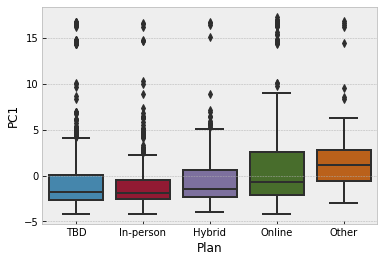

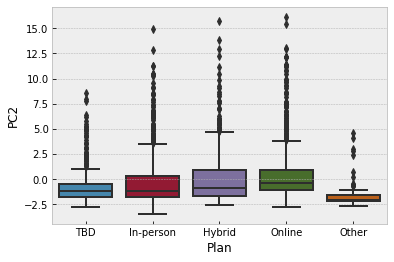

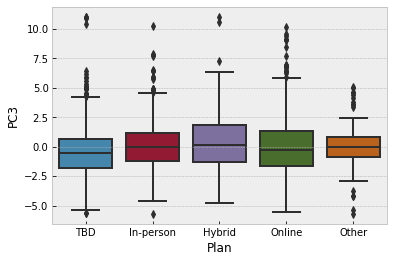

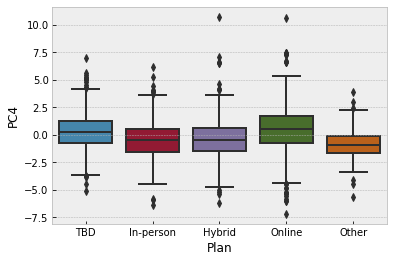

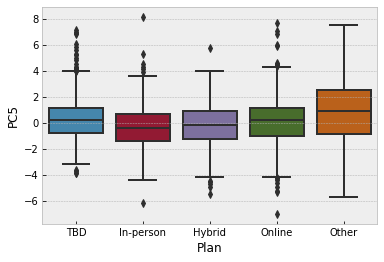

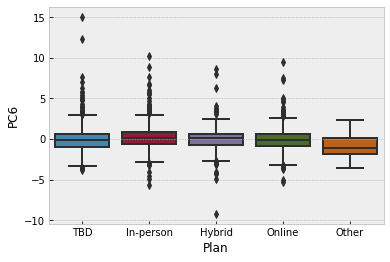

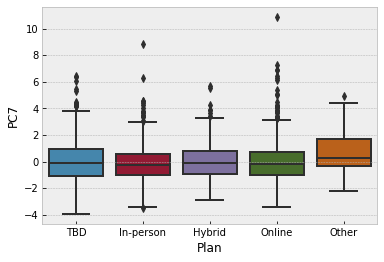

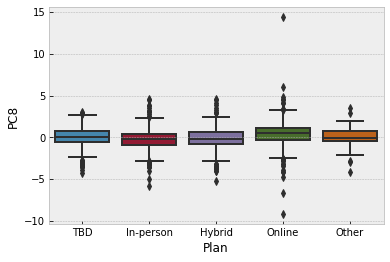

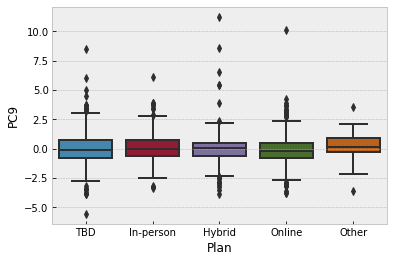

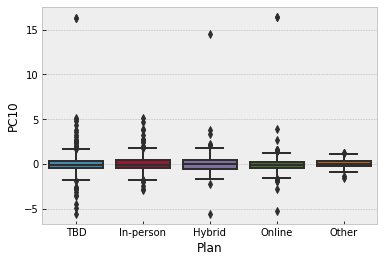

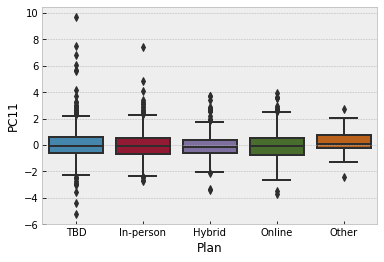

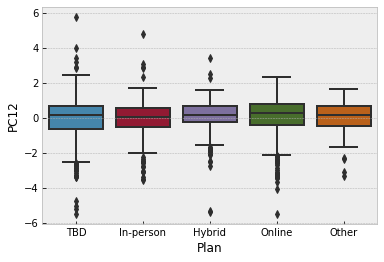

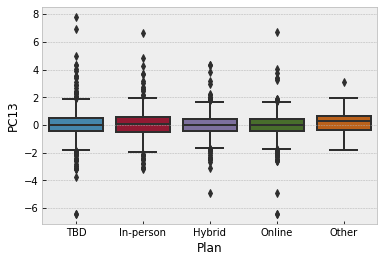

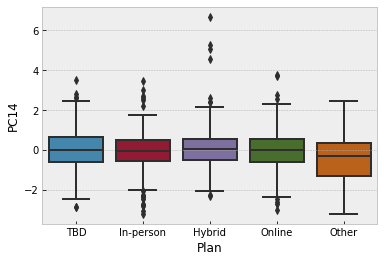

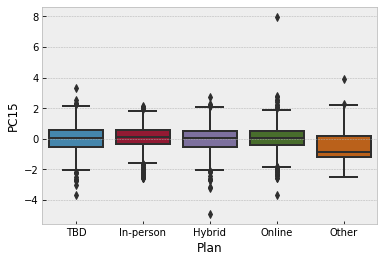

In [68]:
boxplot_col = ['PC{}'.format(i) for i in range(1,16)]
for col in boxplot_col:
    sns.boxplot(data = new_data,  x = 'Plan', y = col)
    plt.show()

In [71]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2433 entries, 0 to 2432
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Control          2433 non-null   object 
 1   State            2433 non-null   object 
 2   Plan             2433 non-null   object 
 3   institution      2433 non-null   object 
 4   Campus_Size      2433 non-null   object 
 5   Housing          2433 non-null   object 
 6   college_year     2433 non-null   object 
 7   city             2433 non-null   object 
 8   county           2433 non-null   object 
 9   state            2433 non-null   object 
 10  Campus_Location  2433 non-null   object 
 11  PC1              2433 non-null   float64
 12  PC2              2433 non-null   float64
 13  PC3              2433 non-null   float64
 14  PC4              2433 non-null   float64
 15  PC5              2433 non-null   float64
 16  PC6              2433 non-null   float64
 17  PC7           

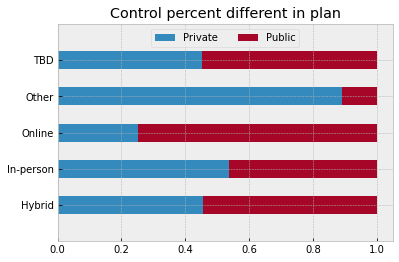

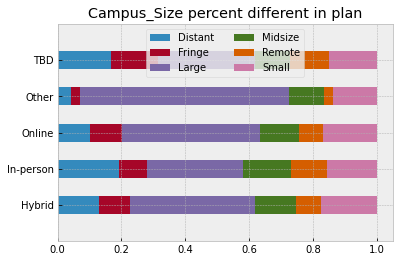

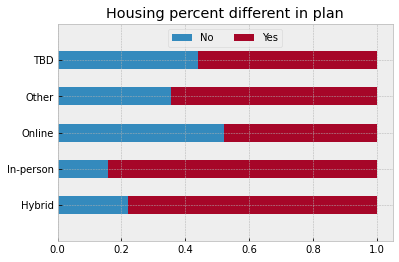

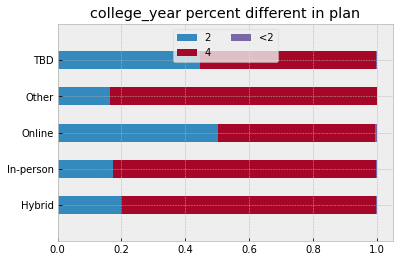

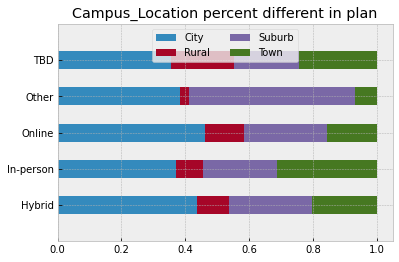

In [79]:
labels = [
    'Control', 'Campus_Size', 'Housing', 'college_year', 'Campus_Location'
]
for label_name in labels:
    new_data.groupby('Plan')[label_name].value_counts(
        normalize=True).sort_index().unstack().plot(kind='barh', stacked=True)
    plt.legend(ncol=2, loc='upper center')
    plt.title(label_name + ' percent different in plan')
    plt.ylim(-1, 5)
    plt.ylabel('')
    plt.show()

# Fitting Model (Classification)

In [81]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "11.0.5" 2019-10-15 LTS; Java(TM) SE Runtime Environment 18.9 (build 11.0.5+10-LTS); Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.5+10-LTS, mixed mode)
  Starting server from /Users/matsujun/opt/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/3w/1j4y1jns6hb89zd6xxfyjzwr0000gn/T/tmp7meghtuq
  JVM stdout: /var/folders/3w/1j4y1jns6hb89zd6xxfyjzwr0000gn/T/tmp7meghtuq/h2o_matsujun_started_from_python.out
  JVM stderr: /var/folders/3w/1j4y1jns6hb89zd6xxfyjzwr0000gn/T/tmp7meghtuq/h2o_matsujun_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.1
H2O_cluster_version_age:,29 days
H2O_cluster_name:,H2O_from_python_matsujun_i0r307
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [82]:
# Transform to H2O Frame, and make sure the target variable is categorical
# classfication 
h2o_df = H2OFrame(new_data)
h2o_df['Plan'] = h2o_df['Plan'].asfactor()

h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,Control,State,Plan,institution,Campus_Size,Housing,college_year,city,county,state,Campus_Location,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
type,enum,enum,enum,enum,enum,enum,int,enum,enum,enum,enum,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real
mins,,,,,,,2.0,,,,,-4.228210878623743,-3.4957575311217215,-5.757650898723498,-7.235378039943386,-7.050586839131251,-9.291107338817968,-3.977919776298819,-9.229218709372477,-5.589516925646049,-5.633949658308438,-5.25562958217274,-5.522595675953574,-6.457781388380441,-3.2168637770824073,-4.947132055371641
mean,,,,,,,3.3063917525773197,,,,,-1.6755260373590986e-15,3.0899761915836876e-17,-3.9099040845258504e-17,1.5829351718288365e-17,-1.356336917779366e-16,3.9010949418744056e-17,6.808789643208968e-17,-9.107298248878237e-17,-1.5373986805844453e-16,3.1238575094738597e-17,9.985502008591496e-17,-5.442694905877232e-17,5.898059818321144e-17,-9.475926987523309e-17,-7.632783294297951e-17
maxs,,,,,,,4.0,,,,,17.31675572573018,16.14878350736237,11.04891638073524,10.721642615079292,8.167044072600119,15.069712920253457,10.88928871087594,14.432896368480382,11.245141791056918,16.442784321497122,9.722357177475638,5.767121498187161,7.80935962331808,6.677209564787843,7.977626567657072
sigma,,,,,,,0.9521018367394896,,,,,4.149251827137591,2.6921773844901136,2.3369800251477533,1.8951214891518924,1.7043831155433184,1.5577607458611256,1.4803914500146838,1.3107600297916004,1.2171825451784044,1.099458146707583,1.0746633992803825,1.0107553665937914,0.9980526185351608,0.9223659096060022,0.9027884575888782
zeros,,,,,,,0,,,,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
missing,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,Public,MT,TBD,Aaniiih Nakoda College,Remote,No,2.0,Harlem,Blaine,MT,Rural,-3.27992060982416,-1.8395551137378436,-2.3673090233024756,0.7295949157909924,0.335072893966466,3.3071117649243384,-1.2858106462846064,1.5066362754872495,0.7905690678630347,-2.7306729022013827,5.717553439957469,2.1091922152144393,0.8595774724130424,-0.43445471212255155,-1.3227347910648577
1,Private,TX,In-person,Abilene Christian University,Midsize,Yes,4.0,Abilene,Taylor,TX,City,-2.3670396932996267,-0.9522696535100652,-0.29152904102892024,-1.0255212387608263,-2.2860399034160994,3.9146514725346826,1.3571755975372446,-0.3478040444646583,0.4979595984462511,1.4918863458881435,0.4776765867278947,-0.27033602752863867,0.049236868176111975,-0.280831326009083,1.182825755462197
2,Private,TX,TBD,Hardin-Simmons University,Midsize,Yes,4.0,Abilene,Taylor,TX,City,-2.565876386857739,-1.6532142399047856,-0.883941512861651,-0.20861478505766232,-1.2688204482809624,3.460472097071236,1.2154454920216458,-0.29930516741138813,0.5454562553178149,1.2878908561638969,0.5856835733872376,-0.17015981487173035,-0.07390643722497446,-0.6972388889412102,-0.0717074761731118


In [83]:
h2o_df.columns

['Control',
 'State',
 'Plan',
 'institution',
 'Campus_Size',
 'Housing',
 'college_year',
 'city',
 'county',
 'state',
 'Campus_Location',
 'PC1',
 'PC2',
 'PC3',
 'PC4',
 'PC5',
 'PC6',
 'PC7',
 'PC8',
 'PC9',
 'PC10',
 'PC11',
 'PC12',
 'PC13',
 'PC14',
 'PC15']

In [88]:
# Split into 75% training and 25% test dataset
strat_split = h2o_df['Plan'].stratified_split(test_frac=0.2, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = ['Control',
 'State',
 'Plan',
 'Campus_Size',
 'Housing',
 'college_year',
 'city',
 'county',
 'Campus_Location',
 'PC1',
 'PC2',
 'PC3',
 'PC4',
 'PC5',
 'PC6',
 'PC7',
 'PC8',
 'PC9',
 'PC10',
 'PC11',
 'PC12',
 'PC13',
 'PC14',
 'PC15']

target = 'Plan'

In [89]:
# Build random forest model
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=10, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [90]:
model.model_performance

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1599595585040_2


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,100.0,500.0,1546893.0,10.0,10.0,10.0,39.0,197.0,117.024




ModelMetricsMultinomial: drf
** Reported on train data. **

MSE: 0.24669924623408457
RMSE: 0.4966882787363565
LogLoss: 0.7340595737847143
Mean Per-Class Error: 0.24350876843880292

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,Hybrid,In-person,Online,Other,TBD,Error,Rate
0,449.0,42.0,41.0,0.0,37.0,0.210896,120 / 569
1,36.0,411.0,71.0,1.0,65.0,0.296233,173 / 584
2,45.0,54.0,396.0,0.0,80.0,0.311304,179 / 575
3,0.0,0.0,7.0,554.0,10.0,0.029772,17 / 571
4,32.0,69.0,108.0,3.0,362.0,0.369338,212 / 574
5,562.0,576.0,623.0,558.0,554.0,0.243996,"701 / 2,873"



Top-5 Hit Ratios: 


,k,hit_ratio
0,1,0.756004
1,2,0.900801
2,3,0.965889
3,4,0.997215
4,5,1.000000



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error
0,,2020-09-08 16:09:52,0.031 sec,0.0,NaN,NaN,NaN
1,,2020-09-08 16:09:52,0.165 sec,1.0,0.629812,11.511966,0.412879
2,,2020-09-08 16:09:52,0.239 sec,2.0,0.611529,10.110976,0.398605
3,,2020-09-08 16:09:52,0.310 sec,3.0,0.601762,8.504782,0.390335
4,,2020-09-08 16:09:52,0.386 sec,4.0,0.595757,7.832486,0.387376
5,,2020-09-08 16:09:52,0.470 sec,5.0,0.564248,6.400850,0.351788
6,,2020-09-08 16:09:52,0.546 sec,6.0,0.560257,5.864816,0.349666
7,,2020-09-08 16:09:52,0.622 sec,7.0,0.557886,5.194686,0.345455
8,,2020-09-08 16:09:52,0.691 sec,8.0,0.551983,4.522068,0.340486
9,,2020-09-08 16:09:52,0.763 sec,9.0,0.550194,3.880869,0.337943



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,county,60995.031250,1.000000,0.454874
1,State,14604.560547,0.239439,0.108914
2,PC2,7169.820312,0.117548,0.053469
3,PC5,4659.015137,0.076384,0.034745
4,city,4521.088379,0.074122,0.033716
5,PC15,4171.174316,0.068385,0.031107
6,PC4,3461.032471,0.056743,0.025811
7,PC14,3036.207764,0.049778,0.022643
8,PC8,2965.248291,0.048615,0.022114
9,Control,2898.247314,0.047516,0.021614



See the whole table with table.as_data_frame()


<bound method ModelBase.model_performance of >

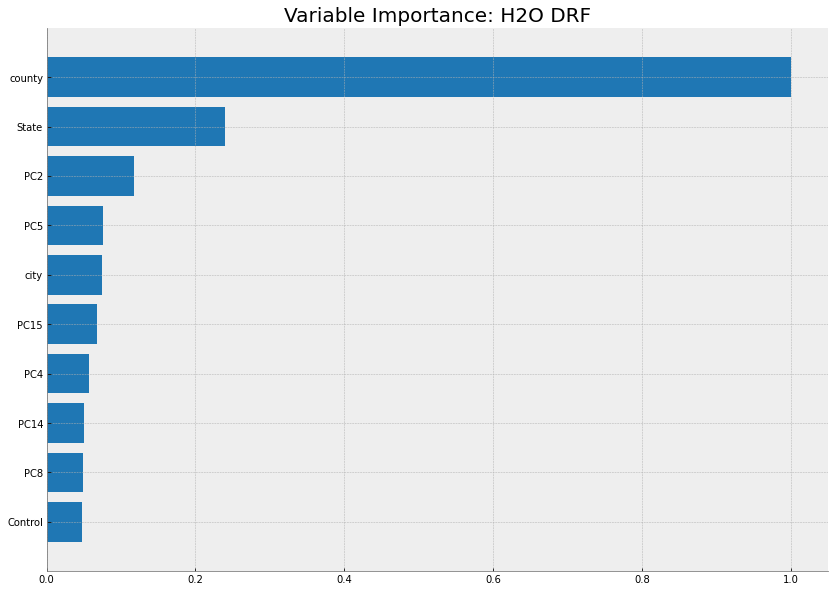

In [91]:
importance = model.varimp_plot()